In [36]:
from geopy.geocoders import Nominatim
import time
from pyproj import Transformer
import requests
import json
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
%matplotlib notebook

In [37]:
# Location we need to geocode

loc = 'Monseigneur Ladeuzeplein 21, 3000 Leuven'

In [39]:
# Finding the coordinates of the location

# Making an instance of Nominatim class
geolocator = Nominatim(user_agent="my_request")
 
# Applying geocode method to get the location
location = geolocator.geocode(loc, timeout = 10)
print(location.latitude)
print(location.longitude)

50.87799745
4.7073196316871515


In [40]:
# Transforming the EPSG of the coordinates

transformer = Transformer.from_crs("epsg:4326", "epsg:31370")
x,y = transformer.transform(location.latitude, location.longitude)
print(x)
print(y)

173827.91470018617
174235.63119708188


In [45]:
# Accessing the CSV file of the dataframe containing the bounds of all the .tif files

df = pd.read_csv('bounds.csv', sep=',')
df.index += 1 
df.head()

,DSM,DTM,left,bottom,right,top
1,https://downloadagiv.blob.core.windows.net/dhm...,https://downloadagiv.blob.core.windows.net/dhm...,145000,238000,162000,247000
2,https://downloadagiv.blob.core.windows.net/dhm...,https://downloadagiv.blob.core.windows.net/dhm...,162000,238000,194000,250000
3,https://downloadagiv.blob.core.windows.net/dhm...,https://downloadagiv.blob.core.windows.net/dhm...,194000,238000,206000,248000
4,https://downloadagiv.blob.core.windows.net/dhm...,https://downloadagiv.blob.core.windows.net/dhm...,53000,218000,66000,225500
5,https://downloadagiv.blob.core.windows.net/dhm...,https://downloadagiv.blob.core.windows.net/dhm...,66000,218000,98000,232000


In [46]:
# Finding the file number that contains the coordinates of the location

bound_file = df[(df['left'] < x) & (df['right'] > x)
             & ((df['bottom'] < y) & (df['top'] > y))]
    
file_num = bound_file.index[0]
file_num

32

In [47]:
# Finding the polygon through Nominatim API

url = f'http://nominatim.openstreetmap.org/search?q={loc}&polygon_geojson=1&format=json&limit=1'

r = requests.get(url)

response = r.json()

polygon = response[0]['geojson']
polygon
# df_poly = pd.DataFrame(response[0]['geojson']['coordinates'][0],columns = ['y_coord', 'x_coord'])
# df_poly

{'type': 'Polygon',
 'coordinates': [[[4.7068792, 50.8778878],
   [4.7070328, 50.8778039],
   [4.7070517, 50.8778176],
   [4.7070736, 50.8778043],
   [4.7071019, 50.8778037],
   [4.707108, 50.8778079],
   [4.7072997, 50.8777018],
   [4.707265, 50.8776818],
   [4.7073416, 50.8776393],
   [4.7074182, 50.8775969],
   [4.7081727, 50.8780295],
   [4.7080953, 50.8780713],
   [4.7080179, 50.8781132],
   [4.7080067, 50.8781058],
   [4.707681, 50.8782849],
   [4.7076909, 50.8782916],
   [4.7076202, 50.8783294],
   [4.7075437, 50.8783716],
   [4.7072774, 50.8781778],
   [4.7071367, 50.8780753],
   [4.7068792, 50.8778878]],
  [[4.7072315, 50.8778961],
   [4.7073341, 50.8779703],
   [4.7075535, 50.8778506],
   [4.7074556, 50.8777888],
   [4.7074207, 50.8778076],
   [4.7074079, 50.8777989],
   [4.7072315, 50.8778961]],
  [[4.7075295, 50.878174],
   [4.7075504, 50.878189],
   [4.7078513, 50.8780246],
   [4.7077099, 50.8779411],
   [4.7075504, 50.8780306],
   [4.7076537, 50.8781061],
   [4.7075295, 5

In [10]:
# Transforming the projection of DSM imagery to specific coordinate system

# Specifing output projection system
dst_crs = 'EPSG:4326'

# Input imagery file name before transformation
input_imagery_file = rio.open(f'D:\\becode_projects\\3D-Houses\\DHMVIIDSMRAS1m_k{file_num}\\GeoTIFF\\DHMVIIDSMRAS1m_k{file_num}.tif', "r")


# Save output imagery file name after transformation
transformed_imagery_file = (f'D:\\becode_projects\\3D-Houses\\DHMVIIDSMRAS1m_k{file_num}\\GeoTIFF\\TRF_DHMVIIDSMRAS1m_k{file_num}.tif')
with input_imagery_file as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rio.band(imagery, i),
                destination=rio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

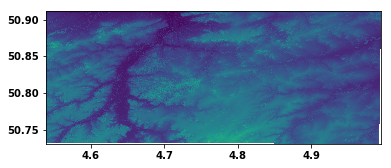

Transformed Imagery file Projection:  EPSG:4326


In [11]:
# Plotting again after transformation. You can observe axis value have changed
tr_imagery_DSM = rio.open(f'D:\\becode_projects\\3D-Houses\\DHMVIIDSMRAS1m_k{file_num}\\GeoTIFF\\TRF_DHMVIIDSMRAS1m_k{file_num}.tif', "r")

# Plotting the trasformed imagery
show(tr_imagery_DSM)

# Checking the coordinate reference system of transformed imagery, if it's changed or not.
print('Transformed Imagery file Projection: ', tr_imagery_DSM.crs)

In [12]:
# Transforming the projection of DTM imagery to specific coordinate system

# Specify output projection system
dst_crs = 'EPSG:4326'

# Input imagery file name before transformation
input_imagery_file = rio.open(f'D:\\becode_projects\\3D-Houses\\DHMVIIDTMRAS1m_k{file_num}\\GeoTIFF\\DHMVIIDTMRAS1m_k{file_num}.tif', "r")
# Save output imagery file name after transformation
transformed_imagery_file = f'D:\\becode_projects\\3D-Houses\\DHMVIIDTMRAS1m_k{file_num}\\GeoTIFF\\TRF_DHMVIIDTMRAS1m_k{file_num}.tif'

with input_imagery_file as imagery:
    transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height, *imagery.bounds)
    kwargs = imagery.meta.copy()
    kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
    with rio.open(transformed_imagery_file, 'w', **kwargs) as dst:
        for i in range(1, imagery.count + 1):
            reproject(
                source=rio.band(imagery, i),
                destination=rio.band(dst, i),
                src_transform=imagery.transform,
                src_crs=imagery.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

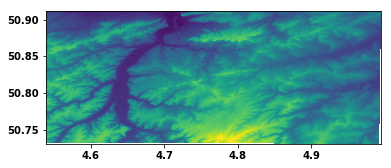

Transformed Imagery file Projection:  EPSG:4326


In [13]:
# Plotting again after transformation. You can observe axis value have changed
tr_imagery_DTM = rio.open(f'D:\\becode_projects\\3D-Houses\\DHMVIIDTMRAS1m_k{file_num}\\GeoTIFF\\TRF_DHMVIIDTMRAS1m_k{file_num}.tif', "r")

# Plotting the trasformed imagery
show(tr_imagery_DTM)

# Checking the coordinate reference system of transformed imagery, if it's changed or not.
print('Transformed Imagery file Projection: ', tr_imagery_DTM.crs)


In [14]:
# Masking the raster using the polygon

In [21]:
# File paths of the transformed files

DSM_fp = f'D:\\becode_projects\\3D-Houses\\DHMVIIDSMRAS1m_k{file_num}\\GeoTIFF\\TRF_DHMVIIDSMRAS1m_k{file_num}.tif'
DTM_fp = f'D:\\becode_projects\\3D-Houses\\DHMVIIDTMRAS1m_k{file_num}\\GeoTIFF\\TRF_DHMVIIDTMRAS1m_k{file_num}.tif'

In [22]:
# Masking DSM with the polygon of the location

with rio.open(DSM_fp) as src:
    out_DSM_img, out_transform = mask(src, [polygon], crop=True, nodata=0, filled=True, indexes=1)
    out_meta_DSM = src.meta

In [23]:
# Masking DTM with the polygon of the location

with rio.open(DTM_fp) as src:
    out_DTM_img, out_transform = mask(src, [polygon], crop=True, nodata=0, filled=True, indexes=1)
    out_meta_DTM = src.meta

In [24]:
# Calculating the Canopy Height Model (CHM) [CHM = DSM - DTM]

out_img_chm = out_DSM_img - out_DTM_img
out_img_chm.shape

(61, 101)

<IPython.core.display.Javascript object>


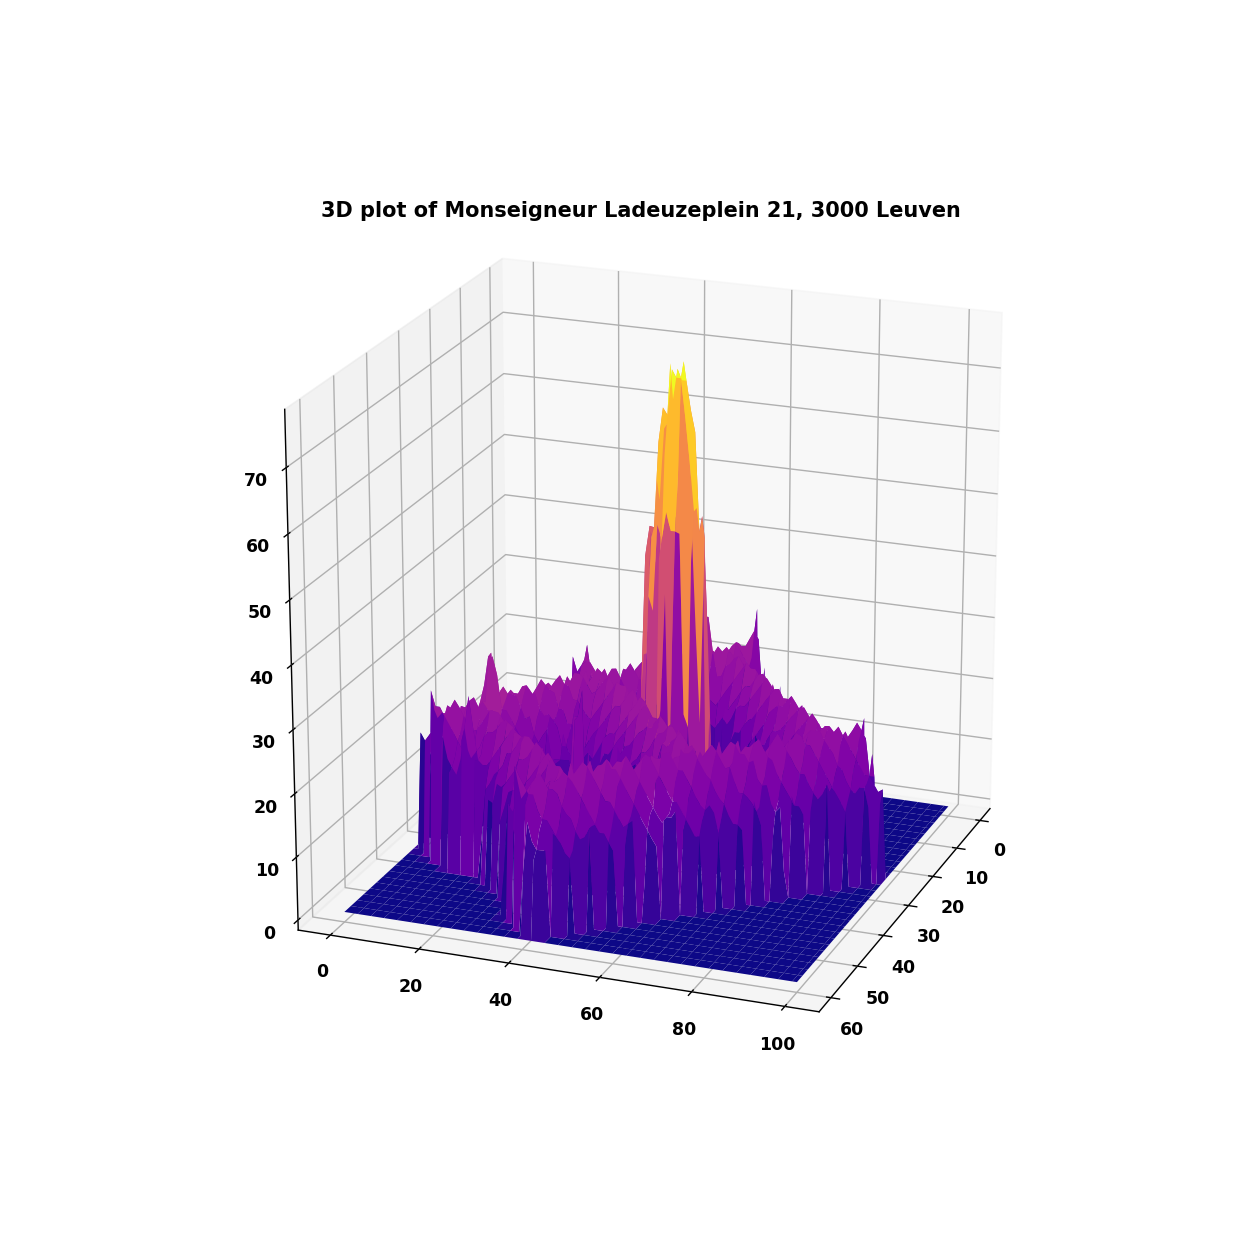

In [35]:
# 3-D Plot using CHM array

# Assigning the x, y and z values
x = range(0, out_img_chm.shape[0])
y = range(0, out_img_chm.shape[1])

x, y = np.meshgrid(x, y, indexing = 'ij')

z = out_img_chm   #elevation  

# creating a figure for plotting
fig = plt.figure(figsize=(10,10))

# Creating plot
ax = fig.add_subplot(111, projection='3d', title= f'3D plot of {loc}')
ax.plot_surface(x, y, z, cmap = 'plasma')

# Showing the above plot
plt.show()

In [26]:
# Plotting the 3-D graph using plotly


fig = go.Figure(data=go.Surface(z=out_img_chm, colorscale = 'sunsetdark', connectgaps=True))
fig.update_layout(title = f'3D Plot of {loc}', scene = dict(
                    xaxis_title='Length (in meters)',
                    yaxis_title='Width (in meters)',
                    zaxis_title='Height (in meters)',

                    xaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",),
                    yaxis = dict(
                        backgroundcolor="rgb(230, 200,230)",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white"),
                    zaxis = dict(
                        backgroundcolor="rgb(230, 230,200)",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white",),),
                    margin=dict(
                    r=20, l=20,
                    b=30, t=40), autosize=False,
                  width=1200, height=1000)
fig.show()